#### The input prompt is an integer 0-9, the output will be the image of the integer. We will use MNIST dataset.

#### 0. Initializing

In [1]:
# Install dependencies
# !pip install einops
# !pip install lpips

In [2]:
# Import library

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools

from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from einops import rearrange
import math
from torch.utils.data import TensorDataset

In [3]:
# run on GPU for acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### 1. Define some functions for UNet


In [4]:
# Get some modules to let time interact

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights (frequencies) during initialization. 
    # These weights (frequencies) are fixed during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    # Cosine(2 pi freq x), Sine(2 pi freq x)
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps.
  Allow time repr to input additively from the side of a convolution layer.
  """
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None] 
    # this broadcast the 2d tensor to 4d, add the same value across space. 


In [5]:
#Diffusion constant and noise strength

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  
  
  Returns:
    The standard deviation.
  """    
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
  
  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)
  
sigma =  25.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [6]:
# Defining the loss function
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  # Sample time uniformly in 0, 1
  random_t = torch.rand(x.shape[0], device=device) * (1. - eps) + eps 
  # Find the noise std at the time `t`
  std = marginal_prob_std(random_t)
  z = torch.randn_like(x) # get normally distributed noise
  perturbed_x = x + std[:,None,None,None]*z

  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

In [7]:
# Sampler code
num_steps = 300
def Euler_Maruyama_sampler(score_model, 
              marginal_prob_std,
              diffusion_coeff, 
              batch_size=64, 
              x_shape=(1, 28, 28),
              num_steps=num_steps, 
              device=device, 
              eps=1e-3, y=None):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns:
    Samples.    
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, *x_shape, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
  # Do not include any noise in the last sampling step.
  return mean_x

#### 2. Define attention modules to get conditional generation to work

In [8]:
# Attention modules

class CrossAttention(nn.Module):
  def __init__(self, embed_dim, hidden_dim, context_dim=None, num_heads=1,):
    """
    Note: For simplicity reason, we just implemented 1-head attention. 
    Feel free to implement multi-head attention! with fancy tensor manipulations.
    """
    super(CrossAttention, self).__init__()
    self.hidden_dim = hidden_dim
    self.context_dim = context_dim
    self.embed_dim = embed_dim
    self.query = nn.Linear(hidden_dim, embed_dim, bias=False)
    if context_dim is None:
      self.self_attn = True 
      self.key = nn.Linear(hidden_dim, embed_dim, bias=False)     
      self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)
    else:
      self.self_attn = False 
      self.key = nn.Linear(context_dim, embed_dim, bias=False)  
      self.value = nn.Linear(context_dim, hidden_dim, bias=False)
    
    
  def forward(self, tokens, context=None):
    # tokens: with shape [batch, sequence_len, hidden_dim]
    # context: with shape [batch, contex_seq_len, context_dim]
    if self.self_attn:
        Q = self.query(tokens)
        K = self.key(tokens)  
        V = self.value(tokens) 
    else:
        # implement Q, K, V for the Cross attention 
        Q = self.query(tokens)
        K = self.key(context)
        V = self.value(context)
    #print(Q.shape, K.shape, V.shape)
    scoremats = torch.einsum("BTH,BSH->BTS", Q, K) # inner product of Q and K, a tensor 
    attnmats = F.softmax(scoremats/np.sqrt(self.embed_dim), dim=-1)  # softmax of scoremats
    #print(scoremats.shape, attnmats.shape, )
    ctx_vecs = torch.einsum("BTS,BSH->BTH", attnmats, V) # weighted average value vectors by attnmats
    return ctx_vecs


class TransformerBlock(nn.Module):
  """The transformer block that combines self-attn, cross-attn and feed forward neural net"""
  def __init__(self, hidden_dim, context_dim):
    super(TransformerBlock, self).__init__()
    self.attn_self = CrossAttention(hidden_dim, hidden_dim, )
    self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim)

    self.norm1 = nn.LayerNorm(hidden_dim)
    self.norm2 = nn.LayerNorm(hidden_dim)
    self.norm3 = nn.LayerNorm(hidden_dim)
    # implement a 2 layer MLP with K*hidden_dim hidden units, and nn.GeLU nonlinearity #######
    self.ffn  = nn.Sequential(nn.Linear(hidden_dim, 3*hidden_dim),
                nn.GELU(), nn.Linear(3*hidden_dim, hidden_dim) )
    
    
  def forward(self, x, context=None):
    # Notice the + x as residue connections
    x = self.attn_self(self.norm1(x)) + x
    # Notice the + x as residue connections
    x = self.attn_cross(self.norm2(x), context=context) + x
    # Notice the + x as residue connections
    x = self.ffn(self.norm3(x)) + x
    return x 

class SpatialTransformer(nn.Module):
  def __init__(self, hidden_dim, context_dim):
    super(SpatialTransformer, self).__init__()
    self.transformer = TransformerBlock(hidden_dim, context_dim)

  def forward(self, x, context=None):
    b, c, h, w = x.shape
    x_in = x
    # Combine the spatial dimensions and move the channel dimen to the end
    x = rearrange(x, "b c h w->b (h w) c")
    # Apply the sequence transformer
    x = self.transformer(x, context)
    # Reverse the process
    x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
    # Residue 
    return x + x_in

In [9]:
# Conditional denoising loss

def loss_fn_cond(model, x, y, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=device) * (1. - eps) + eps  
  z = torch.randn_like(x).to(device=device)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t, y=y)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

#### 3. Latent space diffusion using an autoencoder

##### Train the autoencoder

In [10]:
# Defining an autoencoder
class AutoEncoder(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, channels=[4, 8, 32],):
    """Initialize a time-dependent score-based network.
    Args:
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    # Encoding layers where the resolution decreases
    self.encoder = nn.Sequential(nn.Conv2d(1, channels[0], 3, stride=1, bias=True),
                   nn.BatchNorm2d(channels[0]),
                   nn.SiLU(),
                   nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=True),
                   nn.BatchNorm2d(channels[1]),
                   nn.SiLU(),
                   nn.Conv2d(channels[1], channels[2], 3, stride=1, bias=True),
                   nn.BatchNorm2d(channels[2]),
                   ) #nn.SiLU(),
    self.decoder = nn.Sequential(nn.ConvTranspose2d(channels[2], channels[1], 3, stride=1, bias=True),
                   nn.BatchNorm2d(channels[1]),
                   nn.SiLU(),
                   nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=True, output_padding=1),
                   nn.BatchNorm2d(channels[0]),
                   nn.SiLU(),
                   nn.ConvTranspose2d(channels[0], 1, 3, stride=1, bias=True),
                   nn.Sigmoid(),)
  
  def forward(self, x):
    output = self.decoder(self.encoder(x))
    return output

In [11]:
# # Train the autoencoder with the help of a perceptual loss

# from lpips import LPIPS

# # Define the loss function, MSE and LPIPS 
# lpips = LPIPS(net="squeeze").to(device)
# loss_fn_ae = lambda x,xhat: \
#     nn.functional.mse_loss(x, xhat) + \
#     lpips(x.repeat(1,3,1,1), x_hat.repeat(1,3,1,1)).mean()

# ae_model = AutoEncoder([4, 4, 4]).to(device)
# n_epochs =   250 
batch_size =  4096*6 # size of a mini-batch
# lr=10e-4 # learning rate

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# optimizer = Adam(ae_model.parameters(), lr=lr)
# tqdm_epoch = trange(n_epochs)
# for epoch in tqdm_epoch:
#   avg_loss = 0.
#   num_items = 0
#   for x, y in data_loader:
#     x = x.to(device)    
#     z = ae_model.encoder(x)
#     x_hat = ae_model.decoder(z)
#     loss = loss_fn_ae(x, x_hat) #loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
#     optimizer.zero_grad()
#     loss.backward()    
#     optimizer.step()
#     avg_loss += loss.item() * x.shape[0]
#     num_items += x.shape[0]
#   print('{} Average Loss: {:5f}'.format(epoch, avg_loss / num_items))
#   # Print the averaged training loss so far.
#   tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
#   # Update the checkpoint after each epoch of training.
#   torch.save(ae_model.state_dict(), 'ckpt_ae.pth')

##### Instead of run the complete training, we can use the freezed parameter of autoencoder, by loading the ckpt_ae.pth

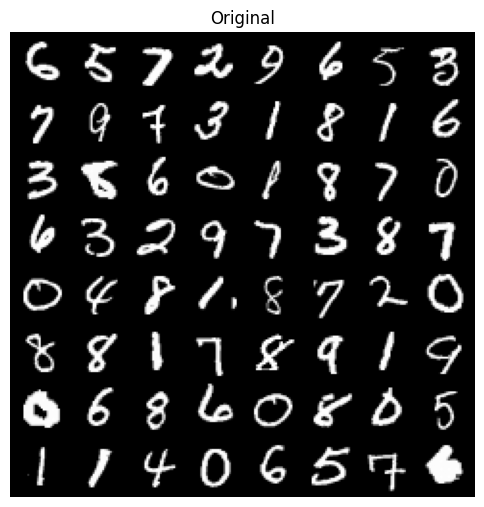

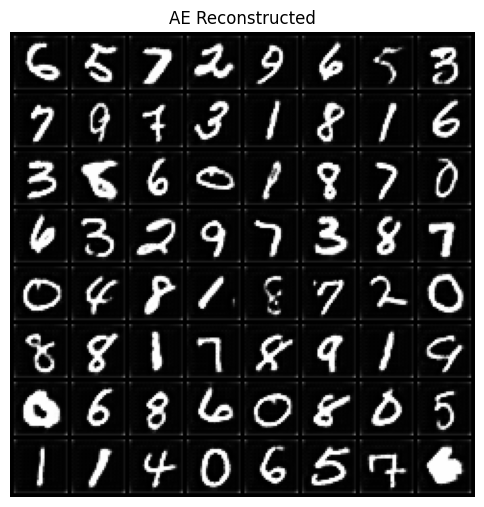

In [12]:
# Visualize trained autoencoder

# Calling the freezed parameter (ckpt_ae.pth)
# Comment this part if you complete the autoencoder training
# -----------------------------------------------------------
ae_model = AutoEncoder([4, 4, 4]).to(device)
checkpoint  = torch.load('ckpt_ae.pth', map_location=device)
ae_model.load_state_dict(checkpoint)
# -----------------------------------------------------------

ae_model.eval()
x, y = next(iter(data_loader))
x_hat = ae_model(x.to(device)).cpu()
plt.figure(figsize=(6,6.5))
plt.axis('off')
plt.imshow(make_grid(x[:64,:,:,:].cpu()).permute([1,2,0]), vmin=0., vmax=1.)
plt.title("Original")
plt.show()

plt.figure(figsize=(6,6.5))
plt.axis('off')
plt.imshow(make_grid(x_hat[:64,:,:,:].cpu()).permute([1,2,0]), vmin=0., vmax=1.)
plt.title("AE Reconstructed")
plt.show()

#### Train the latent diffusion model

In [13]:
# Create latent state dataset

batch_size = 4096*6
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
ae_model.requires_grad_(False)
ae_model.eval()
zs = []
ys = []
for x, y in tqdm(data_loader):
  z = ae_model.encoder(x.to(device)).cpu()
  zs.append(z)
  ys.append(y)

zdata = torch.cat(zs, )
ydata = torch.cat(ys, )

print(zdata.shape)
print(ydata.shape)
print(zdata.mean(), zdata.var())

from torch.utils.data import TensorDataset
latent_dataset = TensorDataset(zdata, ydata)

  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([60000, 4, 10, 10])
torch.Size([60000])
tensor(0.0464) tensor(0.9847)


In [14]:
# Transformer UNet model for latents
class Latent_UNet_Tranformer(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[4, 64, 128, 256], embed_dim=256, 
               text_dim=256, nClass=10):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.time_embed = nn.Sequential(
        GaussianFourierProjection(embed_dim=embed_dim),
        nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(channels[0], channels[1], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[1])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[1])
    self.conv2 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[2])
    self.gnorm2 = nn.GroupNorm(4, num_channels=channels[2])
    self.attn2 = SpatialTransformer(channels[2], text_dim)
    self.conv3 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[3])
    self.gnorm3 = nn.GroupNorm(4, num_channels=channels[3])   
    self.attn3 = SpatialTransformer(channels[3], text_dim) 
    
    self.tconv3 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False, )    
    self.dense6 = Dense(embed_dim, channels[2])
    self.tgnorm3 = nn.GroupNorm(4, num_channels=channels[2])
    self.attn6 = SpatialTransformer(channels[2], text_dim)
    self.tconv2 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)     # + channels[2]
    self.dense7 = Dense(embed_dim, channels[1])
    self.tgnorm2 = nn.GroupNorm(4, num_channels=channels[1])
    self.tconv1 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=1) # + channels[1]
    
    # The swish activation function
    self.act = nn.SiLU() # lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
    self.cond_embed = nn.Embedding(nClass, text_dim)
  
  def forward(self, x, t, y=None): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.time_embed(t))    
    y_embed = self.cond_embed(y).unsqueeze(1)
    # Encoding path
    ## Incorporate information from t
    h1 = self.conv1(x) + self.dense1(embed)
    ## Group normalization
    h1 = self.act(self.gnorm1(h1))
    h2 = self.conv2(h1) + self.dense2(embed)
    h2 = self.act(self.gnorm2(h2))
    h2 = self.attn2(h2, y_embed)
    h3 = self.conv3(h2) + self.dense3(embed)
    h3 = self.act(self.gnorm3(h3))
    h3 = self.attn3(h3, y_embed)

    # Decoding path
    ## Skip connection from the encoding path
    h = self.tconv3(h3) + self.dense6(embed)
    h = self.act(self.tgnorm3(h))
    h = self.attn6(h, y_embed)
    h = self.tconv2(h + h2)
    h += self.dense7(embed)
    h = self.act(self.tgnorm2(h))
    h = self.tconv1(h + h1)

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [15]:
# #Training Latent diffusion model

# continue_training = False 
# if not continue_training:
#   print("initilize new score model...")
#   latent_score_model = torch.nn.DataParallel(
#     Latent_UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn,
#                            channels=[4, 16, 32, 64], ))
#   latent_score_model = latent_score_model.to(device)

# n_epochs = 1000
# batch_size =  9 # size of a mini-batch
# lr=1e-6 # learning rate

# latent_data_loader = DataLoader(latent_dataset, batch_size=batch_size, shuffle=True,)
# latent_score_model.train()
# optimizer = Adam(latent_score_model.parameters(), lr=lr)
# scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.5, 0.995 ** epoch))
# tqdm_epoch = trange(n_epochs)
# for epoch in tqdm_epoch:
#   avg_loss = 0.
#   num_items = 0
#   for z, y in latent_data_loader:
#     z = z.to(device)
#     y = y.to(device)
#     loss = loss_fn_cond(latent_score_model, z, y, marginal_prob_std_fn)
#     optimizer.zero_grad()
#     loss.backward()    
#     optimizer.step()
#     avg_loss += loss.item() * z.shape[0]
#     num_items += z.shape[0]
#   scheduler.step()
#   lr_current = scheduler.get_last_lr()[0]
#   print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
#   tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))  # Print the averaged training loss so far.
#   torch.save(latent_score_model.state_dict(), 'ckpt_latent_diff_transformer.pth') # Update the checkpoint after each epoch of training.

C:\Users\user\AppData\Local\Temp\ipykernel_21604\3613925853.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\user\AppData\Local\Temp\ipykernel_21604\3613925853.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


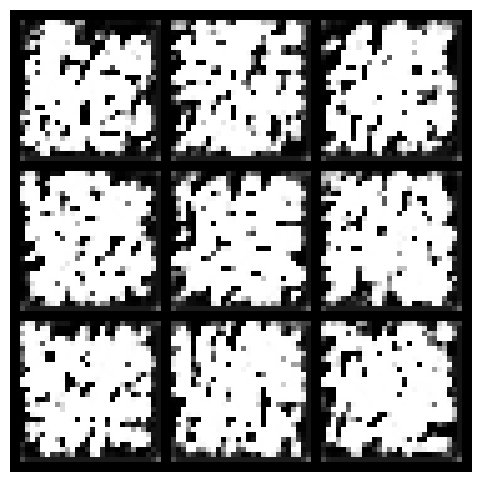

In [17]:
# Inferencing (or sampler)

# Calling the freezed parameter (ckpt_latent_diff_transformer.pth)
# Comment this part if you complete the ldm training
# -----------------------------------------------------------
latent_score_model = torch.nn.DataParallel( Latent_UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn,
                           channels=[4, 16, 32, 64], ))
latent_score_model = latent_score_model.to(device)
checkpoint_ldm  = torch.load('ckpt_latent_diff_transformer.pth', map_location=device)
latent_score_model.load_state_dict(checkpoint_ldm)
# -----------------------------------------------------------

digit = 4 # input prompt
sample_batch_size =9
num_steps = 500
sampler = Euler_Maruyama_sampler #['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler']

latent_score_model.eval()
## Generate samples using the specified sampler.
samples_z = sampler(latent_score_model, 
        marginal_prob_std_fn,
        diffusion_coeff_fn, 
        sample_batch_size, 
        num_steps=num_steps,
        device=device,
        x_shape=(4,10,10),
        y=digit*torch.ones(sample_batch_size, dtype=torch.long))

## Sample visualization.
decoder_samples = ae_model.decoder(samples_z).clamp(0.0, 1.0)
sample_grid = make_grid(decoder_samples, nrow=int(np.sqrt(sample_batch_size)))
%matplotlib inline

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()